# PyTorch Computer Vision

## 목차
1. 실행 환경 세팅
2. FashionMNIST dataset 다운로드
3. 다운로드 받은 image visualize하는 함수 만들기 + 테스트
3. FashionMNIST를 DataLoader화 하기
    - Batch화라던지 data를 shuffle한다든지 하는걸 더 편리하게 할 수 있음
    - DataLoader에 대한 것은 다음 section인 Custom DataSets에서 좀 더 자세히 다룬다
4. Training loop / Test loop function 만들기
5. Linear Model 만들어서 테스트 해 보기
   - Linear model은 flatten을 통해 1차원으로 만들어야 한다
   - 생각보다는 결과가 잘 나온다
6. Non-linear model로 만들어서 테스트 해보기

In [43]:
# 1. 실행 환경 세팅

import matplotlib.pyplot

import mlxtend  # confusion matrix 용

import random

import time
import timeit   # 시간 재기 용

import torch
import torch.nn
import torch.utils.data

import torchmetrics
import torchmetrics.functional

import torchvision
import torchvision.datasets
import torchvision.transforms

import tqdm.auto  # progress bar 용

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
# 2. FashionMNIST dataset 다운로드

# training data
train_data = torchvision.datasets.FashionMNIST(
    root="data_FashionMNIST",                    # 다운로드 할 폴더 이름
    train=True,                                  # train/test data 여부. True면 train data를 다운로드
    download=True,                               # 디스크에 없으면 다운로드 한다
    transform=torchvision.transforms.ToTensor(), # 다운로드시 PIL format으로 오므로 Torch tensor로 변환해 준다
    target_transform=None                        # Label transform도 가능함. 여기서는 하지 않는다
)

# test data
test_data = torchvision.datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False,                                 # train/test data 여부. False면 test data를 다운로드
    download=True,
    transform=torchvision.transforms.ToTensor()
)

class_names = train_data.classes

# 10개의 class가 있다
print(f'class_names : {class_names} (count: {len(class_names)})')

# train data는 60,000개, test data는 10,000개가 있다
print(f'len(train_data.data):    {len(train_data.data)}')
print(f'len(train_data.targets): {len(train_data.targets)}')
print(f'len(test_data.data):     {len(test_data.data)}')
print(f'len(test_data.targets):  {len(test_data.targets)}')

class_names : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] (count: 10)
len(train_data.data):    60000
len(train_data.targets): 60000
len(test_data.data):     10000
len(test_data.targets):  10000


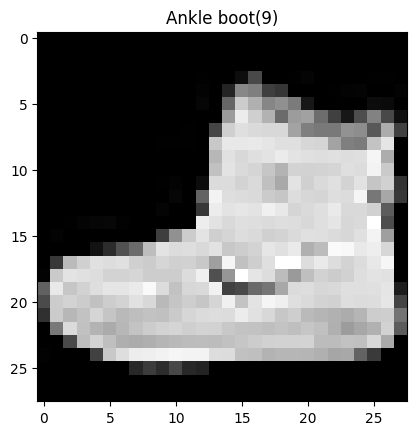

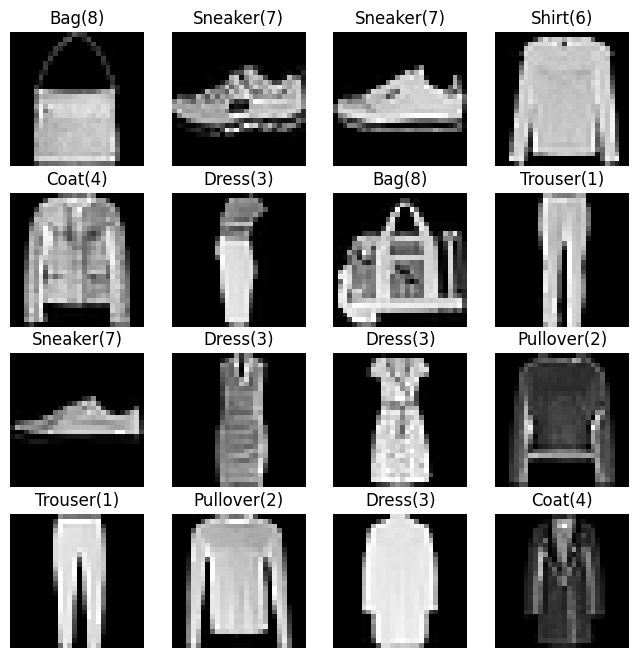

In [45]:
# 다운로드 받은 image visualize하는 함수 만들기 + 테스트

def display_grayscale_image(image, title=None):
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.imshow(image, cmap='gray')
    matplotlib.pyplot.show()

def display_image_table(rows, cols, title_image_pair_list):
    fig = matplotlib.pyplot.figure(figsize=(cols*2, rows*2))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)
        title, image = title_image_pair_list[i]
        matplotlib.pyplot.title(title)
        matplotlib.pyplot.imshow(image, cmap='gray')
        matplotlib.pyplot.axis(False) # axis는 보이지 않게 한다
    matplotlib.pyplot.show()

# train data의 첫번째 이미지를 확인해 본다
image, label = train_data[0]
image = image.squeeze() # squeeze()를 해 주어야 imshow가 정상적으로 작동한다
display_grayscale_image(image, f'{class_names[label]}({label})')

# train data에서 10개를 random하게 선택해 확인해 본다
rows, cols = 4,4
random_idx_list = random.sample(range(len(train_data)), rows*cols)
title_image_pair_list = []
for ri in random_idx_list:
    image, label = train_data[ri]
    # image.squeeze()를 해 주어야 imshow가 정상적으로 작동한다
    title_image_pair_list.append((f'{class_names[label]}({label})', image.squeeze()))

display_image_table(rows, cols, title_image_pair_list)


In [46]:
# 3. FashionMNIST를 DataLoader화 하기
#     - Batch화라던지 data를 shuffle한다든지 하는걸 더 편리하게 할 수 있음
#     - DataLoader에 대한 것은 다음 section인 Custom DataSets에서 좀 더 자세히 다룬다

BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(
    train_data,             # dataset to turn into iterable
    batch_size=BATCH_SIZE,  # how many samples per batch? 
    shuffle=True            # 매 epoch마다 data를 shuffle한다
)

test_dataloader = torch.utils.data.DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # test data는 shuffle할 필요가 없다
)

# dataloader의 shape 확인
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print()

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print()

# 각 batch의 생김새
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f'train_features_batch.shape = {train_features_batch.shape}') # torch.Size([32, 1, 28, 28])
print(f'train_labels_batch.shape = {train_labels_batch.shape}') # torch.Size([32])

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ff5fcfbe690>, <torch.utils.data.dataloader.DataLoader object at 0x7ff5fcfee650>)

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32

train_features_batch.shape = torch.Size([32, 1, 28, 28])
train_labels_batch.shape = torch.Size([32])


In [47]:
# 4. Training loop / Test loop function 만들기
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    
    train_loss = 0.0
    train_precision = 0.0
    train_recall = 0.0

    model.to(device)

    for bi, (X,y) in enumerate(data_loader): # batch 단위로 주어진다
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # # 2. Calculate loss
        loss = loss_fn(y_pred, y) # loss는 하나의 scalar로 나온다
        train_loss += loss

        train_precision += torchmetrics.functional.precision(y_pred, y, task='multiclass', num_classes=10, average='micro')
        train_recall += torchmetrics.functional.recall(y_pred, y, task='multiclass',num_classes=10, average='micro')
    
        # 3. Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 4. Calculate average loss
    train_loss /= len(data_loader)
    train_precision /= len(data_loader)
    train_recall /= len(data_loader)

    print(f'train_loss: {train_loss}    train_precision: {train_precision}    train_recall: {train_recall}')


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    
    test_loss = 0.0
    test_precision = 0.0
    test_recall = 0.0

    model.to(device)
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_precision += torchmetrics.functional.precision(test_pred, y, task='multiclass', num_classes=10, average='micro')
            test_recall += torchmetrics.functional.recall(test_pred, y, task='multiclass', num_classes=10, average='micro')
        
        test_loss /= len(data_loader)
        test_precision /= len(data_loader)
        test_recall /= len(data_loader)

    print(f'test_loss: {test_loss}    test_precision: {test_precision}    test_recall: {test_recall}')

In [48]:
# 5. Linear Model 만들어서 테스트 해 보기
#    - Linear model은 flatten을 통해 1차원으로 만들어야 한다
#    - 생각보다는 결과가 잘 나온다

class FashionMNISTLinearClassifier(torch.nn.Module):
    def __init__(self, input_shape, output_shape, hidden_unit_list):
        super().__init__()
        
        layer_list = []
        layer_list.append(torch.nn.Flatten())
        layer_list.append(torch.nn.Linear(input_shape, hidden_unit_list[0]))
        for i in range(len(hidden_unit_list) - 1):
            layer_list.append(torch.nn.Linear(hidden_unit_list[i], hidden_unit_list[i+1]))
        layer_list.append(torch.nn.Linear(hidden_unit_list[-1], output_shape))

        self.layers = torch.nn.Sequential(*layer_list)
    
    def forward(self, X):
        return self.layers(X)
    
# train data의 첫번째 이미지에서 크기를 가져온다
image, label = train_data[0]
image_size = image.shape[1] * image.shape[2]
    
model_linear = FashionMNISTLinearClassifier(
    input_shape  = image_size,
    output_shape = len(class_names),
    hidden_unit_list = [128, 64, 32]
).to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_linear.parameters(), lr=0.01)
epochs = 3 # 3 이상 하면 오히려 precision/recall이 떨어진다

t_start = timeit.default_timer()

for e in range(epochs):
    print(f'Epoch: {e+1}/{epochs}')
    train_step(model_linear, train_dataloader, loss_func, optimizer)
    test_step(test_dataloader, model_linear, loss_func)

t_end = timeit.default_timer()

print(f'Elapsed time: {t_end - t_start:.2f} seconds')


Epoch: 1/3
train_loss: 0.6818259358406067    train_precision: 0.7677333354949951    train_recall: 0.7677333354949951
test_loss: 0.7760186791419983    test_precision: 0.7651757001876831    test_recall: 0.7651757001876831
Epoch: 2/3
train_loss: 1.9453822374343872    train_precision: 0.8047833442687988    train_recall: 0.8047833442687988
test_loss: 0.5587331652641296    test_precision: 0.8050119876861572    test_recall: 0.8050119876861572
Epoch: 3/3
train_loss: 0.49261438846588135    train_precision: 0.8295166492462158    train_recall: 0.8295166492462158
test_loss: 0.5411955714225769    test_precision: 0.8153953552246094    test_recall: 0.8153953552246094
Elapsed time: 22.21 seconds


In [49]:
# 6. Non-linear model도 테스트 해 보기
#    - Linear model보다는 결과가 좋다
#    - 하지만 epoch 4-5 정도부터는 overfitting이 발생한다

class FashionMNISTMLPClassifier(torch.nn.Module):
    def __init__(self, input_shape, output_shape, hidden_unit_list):
        super().__init__()
        
        layer_list = []
        layer_list.append(torch.nn.Flatten())
        layer_list.append(torch.nn.Linear(input_shape, hidden_unit_list[0]))
        layer_list.append(torch.nn.ReLU())
        for i in range(len(hidden_unit_list) - 1):
            layer_list.append(torch.nn.Linear(hidden_unit_list[i], hidden_unit_list[i+1]))
            layer_list.append(torch.nn.ReLU())
        layer_list.append(torch.nn.Linear(hidden_unit_list[-1], output_shape))

        self.layers = torch.nn.Sequential(*layer_list)
    
    def forward(self, X):
        return self.layers(X)
    
# train data의 첫번째 이미지에서 크기를 가져온다
image, label = train_data[0]
image_size = image.shape[1] * image.shape[2]
    
model_mlp = FashionMNISTMLPClassifier(
    input_shape  = image_size,
    output_shape = len(class_names),
    hidden_unit_list = [128, 64, 32]
).to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.01)
epochs = 5
t_start = timeit.default_timer()

# epoch 4-5 정도부터는 overfitting이 발생한다

for e in range(epochs):
    print(f'Epoch: {e+1}/{epochs}')
    train_step(model_mlp, train_dataloader, loss_func, optimizer)
    test_step(test_dataloader, model_mlp, loss_func)

t_end = timeit.default_timer()

print(f'Elapsed time: {t_end - t_start:.2f} seconds')

Epoch: 1/5
train_loss: 0.5705426335334778    train_precision: 0.7926000356674194    train_recall: 0.7926000356674194
test_loss: 0.5873976349830627    test_precision: 0.810802698135376    test_recall: 0.810802698135376
Epoch: 2/5
train_loss: 0.45115000009536743    train_precision: 0.8392666578292847    train_recall: 0.8392666578292847
test_loss: 0.4681418836116791    test_precision: 0.8347643613815308    test_recall: 0.8347643613815308
Epoch: 3/5
train_loss: 0.42632296681404114    train_precision: 0.8486833572387695    train_recall: 0.8486833572387695
test_loss: 0.4890223443508148    test_precision: 0.8348641991615295    test_recall: 0.8348641991615295
Epoch: 4/5
train_loss: 0.4135865867137909    train_precision: 0.8534166812896729    train_recall: 0.8534166812896729
test_loss: 0.4451557695865631    test_precision: 0.8476437330245972    test_recall: 0.8476437330245972
Epoch: 5/5
train_loss: 0.4040938913822174    train_precision: 0.8577166795730591    train_recall: 0.8577166795730591
tes